In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from collections import Counter

In [3]:
import model_evaluation_utils as meu

In [4]:
import eli5
import shap

shap.initjs()

In [5]:
#get the cleaned version of data from shap
data, labels = shap.datasets.adult(display = True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)

(32561, 12) (32561,)


In [6]:
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [7]:
#now a look at the labels
Counter(labels)

Counter({0: 24720, 1: 7841})

### Basic feature engineering

In [8]:
#keep the original dataset without the encoding for use later for explanability etc
data_disp,  labels_disp = shap.datasets.adult(display = True)

In [9]:
#convert categorical columns with string values to numeric representations
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


### Building train and test datasets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
#split the raw dataset into its train and tests data
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size = 0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head()

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,Self-emp-not-inc,9.0,Married-civ-spouse,Farming-fishing,Wife,White,Female,0.0,2179.0,12.0,United-States
1216,48.0,Self-emp-not-inc,10.0,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40.0,United-States
27962,23.0,State-gov,10.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States
23077,56.0,Local-gov,9.0,Divorced,Exec-managerial,Not-in-family,White,Female,0.0,0.0,40.0,United-States
10180,17.0,Private,7.0,Never-married,Priv-house-serv,Own-child,White,Female,0.0,0.0,9.0,United-States


In [12]:
#create splits for encoded dataset that will be used for training the model
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape)
X_train.head()

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,6,9.0,2,5,5,4,0,0.0,2179.0,12.0,39
1216,48.0,6,10.0,2,3,0,0,1,7688.0,0.0,40.0,39
27962,23.0,7,10.0,2,10,0,4,1,0.0,0.0,30.0,39
23077,56.0,2,9.0,0,4,1,4,0,0.0,0.0,40.0,39
10180,17.0,4,7.0,4,9,3,4,0,0.0,0.0,9.0,39


### Training the classification model

In [13]:
import xgboost as xgb

xgc = xgb.XGBClassifier(n_estimators = 500, max_depth = 5, base_score = 0.5, objective = 'binary:logistic', random_state = 42)

xgc.fit(X_train, y_train)

[19:18:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Making predictions on the test data

In [14]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

### Model performance and evaluation

In [15]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8662
Precision: 0.8623
Recall: 0.8662
F1 Score: 0.8635

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      7455
           1       0.74      0.66      0.70      2314

    accuracy                           0.87      9769
   macro avg       0.82      0.80      0.81      9769
weighted avg       0.86      0.87      0.86      9769


Prediction Confusion Matrix:
------------------------------
[[6925  530]
 [ 777 1537]]


### Feature importances from XGB

Note that they all contradict each other, which motivates the use of model interpretation frameworks like SHAP which uses something known as SHAP values, which claim to come with consistency guarantees (meaning they will typically order the features correctly).

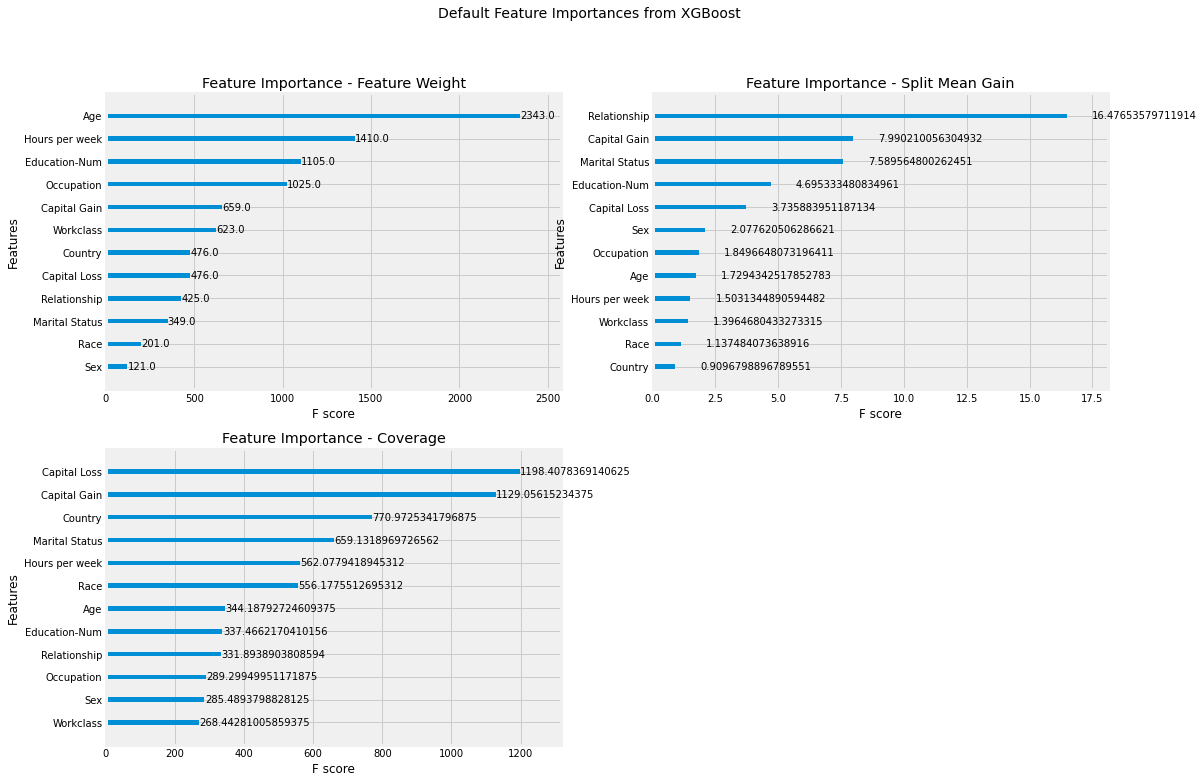

In [16]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize = 14)

#feature importance based on Feature Weights
ax1 = fig.add_subplot(2, 2, 1)
xgb.plot_importance(xgc, importance_type = 'weight', ax = ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

#feature importance based on Gain
ax2 = fig.add_subplot(2, 2, 2)
xgb.plot_importance(xgc, importance_type = 'gain', ax = ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

#feature importance based on Coverage
ax3 = fig.add_subplot(2, 2, 3)
xgb.plot_importance(xgc, importance_type = 'cover', ax = ax3)
t = ax3.set_title("Feature Importance - Coverage")

### Model Interpretation with ELI5

In [18]:
#get feature importances (by default Eli5 uses gain)
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.3225,Relationship
0.1564,Capital Gain
0.1485,Marital Status
0.0919,Education-Num
0.0731,Capital Loss
0.0407,Sex
0.0362,Occupation
0.0339,Age
0.0294,Hours per week
0.0273,Workclass


Predicting when a person's income <= $50k

In [20]:
doc_num = 0
print('Actual Label: ', y_test[doc_num])
print('Predicted Label: ', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num],
                        feature_names = list(data.columns),
                        show_feature_values = True)

Actual Label:  0
Predicted Label:  0


###### Most influential features are Age, Hours per week, Marital Status, Occupation, Relationship, 

Predicting when a person's income >$50k

In [21]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns), 
                     show_feature_values=True)

Actual Label: 1
Predicted Label: 1


###### Most influential features are Education, Relationship, Occupation, Hours per week, Marital Status

### Model interpretation with Skater

In [44]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

###### - Local Models(InMemoryModel): To create a skater model based on a local function or method, pass in the predict function to an InMemoryModel. A user can optionally pass data samples to the examples keyword argument. This is only used to infer output types and formats. Out of the box, skater allows models return numpy arrays and pandas dataframes.
###### - Operationalized Model(DeployedModel): If your model is accessible through an API, use a DeployedModel, which wraps the requests library. DeployedModels require two functions, an input formatter and an output formatter, which speak to the requests library for posting and parsing. The input formatter takes a pandas DataFrame or a numpy ndarray, and returns an object (such as a dict) that can be converted to JSON to be posted. The output formatter takes a requests.response as an input and returns a numpy ndarray or pandas DataFrame.

In [49]:
interpreter = Interpretation(training_data=X_test, 
                             feature_names=list(data.columns))
                             
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
                         target_names=['$50K or less', 'More than $50K'])

Feature importances with Skater

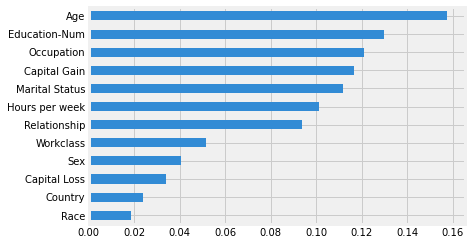

In [52]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False)

### Partial Dependence

The partial dependence plot (PDP or PD plot) shows the marginal effect of a feature on the predicted outcome of a previously fit model. PDPs can show if the relationship between the target and a feature is linear, monotonic or more complex. Skater can show 1-D as well as 2-D PDPs

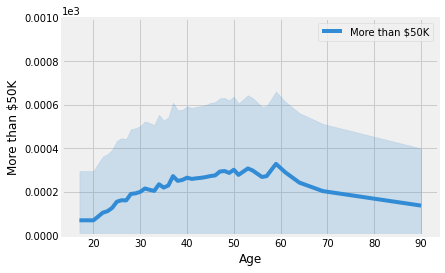

In [53]:
#PDP of Age and its effects on model predictions
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1)

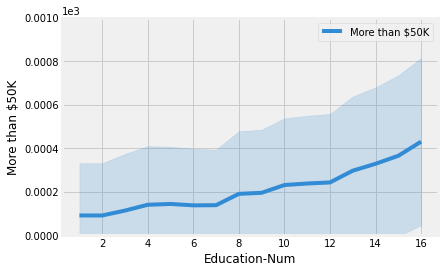

In [54]:
#Education-num feature effect on model prections
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

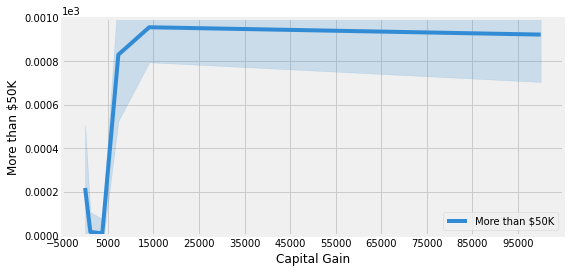

In [55]:
#PDP of 'Capital Gain' affecting model prediction
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (8, 4), n_samples=23000)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

       Relationship  Relationship
0     Not-in-family             1
1           Husband             0
4              Wife             5
12        Own-child             3
17        Unmarried             4
74   Other-relative             2


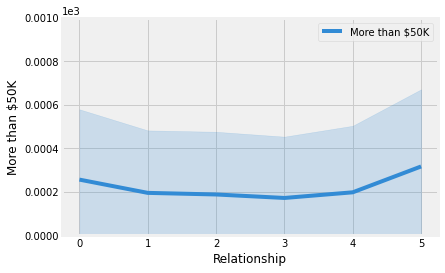

In [58]:
#PDP of coded 'Relationship' affecting model prediction
print(pd.concat([data_disp[['Relationship']], data[['Relationship']]], 
          axis=1).drop_duplicates()) #the coding used

r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1)

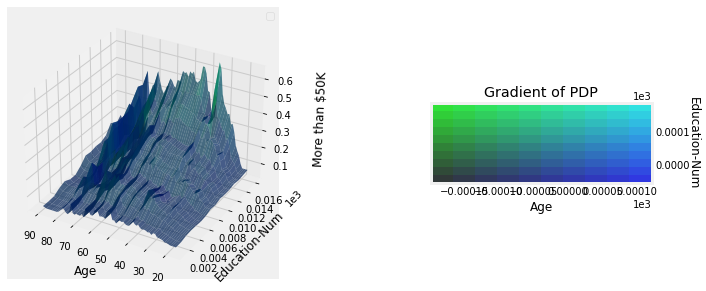

In [59]:
#Two-way PDP showing interactions between features ‘Age’ and ‘Education-Num’ and their effect on making more than $50K
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

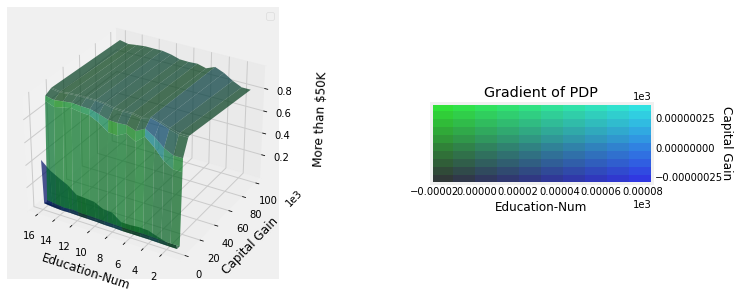

In [60]:
#Two-way PDP showing interactions between features ‘Education-Num’ and ‘Capital Gain’ and their effect on making more than $50K
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Capital Gain')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)
